In [4]:
import os 
import sys
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import time 

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sys.path.append("../src")
from load import *
from util import * 
from pegasos import *

%matplotlib inline

In [5]:
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (10,10)

# Problem 2

Consider the function 
$$ f(x) = \max_{i=1,\ldots,m} f_i(x)$$

Let $k$ be any index such that $f_k(a) = f(a)$ and $g \in \partial f_k(x)$. That is, $f_k(a)$ achieves the maximum and has a subgradient $g$. A subgradient $h$ of $f(a)$ must satisfy the following inequality

$$f(x) \ge f(a) + h^T(x-a)$$

Since $f(a) = f_k(a)$ then we immediately have that $g\in \partial f(a)$

Defining the hinge loss cost function as $J(w) = \max \{0, 1- yw^Tx\}$ a subgradient is easily seen to be

$$ g = 
\begin{cases} 
      0 & 1 < yw^Tx \\
      -yx & yw^Tx \le 1
   \end{cases}
$$

# Problem 3

### Problem 3.1

The perceptron loss is given by $\ell(\hat{y}, y) = \max\{0, -\hat{y}y\}$. If the data is separated by a hyperplane $w^Tx=0$ then the average perceptron loss is given by 

$$
\begin{align*}
Loss &= \frac{1}{n}\sum_{i=1}^n \max\{0, -\hat{y}_iy_i\}\\
&= \frac{1}{n}\sum_{i=1}^n \max\{0, -1\}\\
&= 0
\end{align*}
$$
where the penultimate line uses the fact that the prediction matches the label, both of which are in $\{-1,1\}$

### Problem 3.2

The SSGD rule for optimizing the perceptron loss is given by 

$$ w_{i+1} = 
\begin{cases} 
      w_{i} & \mathbf{sign}(w^Tx_i)y_i > 0 \\
      w_{i} + \eta y_ix_i& \mathbf{sign}(w^Tx_i)y_i \le 0\\
\end{cases}
$$

Choosing $\eta=1$ we see that the rule amounts to adding $yx$ to the weight vector only if a mistake is made

### Problem 3.3

From the SSGD rule we see immediately that the optimal $w$ is given by 
$$w^\star = \sum_{i=1}^n \alpha y_i x_i$$

The support vectors are the examples for which a mistake was made.

# Problem 4

In [6]:
pickle_data_file = 'pickle_data.pkl'
if not os.path.isfile(pickle_data_file):
    pos_path = os.path.join('..', 'data', 'pos')
    neg_path = os.path.join('..', 'data', 'neg')
    shuffle_data(pos_path=pos_path, neg_path=neg_path)
    
with open(pickle_data_file, 'rb') as f:
    movie_data = pickle.load(f)
    
movie_train, movie_test = train_test_split(movie_data, test_size=500, random_state=42)

# Problem 5

In [7]:
movie_train_data, y_train = zip(*[(' '.join(data[:-1]), data[-1]) for data in movie_train])
sparse_movie_train = [Counter(review.split(' ')) for review in movie_train_data]

In [8]:
print('There are {} movies in train'.format(len(sparse_movie_train)))

There are 1500 movies in train


In [9]:
movie_test_data, y_test = zip(*[(' '.join(data[:-1]), data[-1]) for data in movie_test])
sparse_movie_test = [Counter(review.split(' ')) for review in movie_test_data]

In [10]:
print('There are {} movies in test'.format(len(sparse_movie_test)))

There are 500 movies in test


In [11]:
vocab_size = len(set().union(*sparse_movie_train))

print('The training set has vocab size {0:,}'.format(vocab_size))

The training set has vocab size 43,153


# Problem 6

The SVM optimization problem from the Pegasos paper is given by 
$$\min_{w} \frac{\lambda}{2}||w||^2 + \frac{1}{m}\sum_{i=1}^m \max\left\{0, 1- y_iw^Tx_i\right\}$$
where the stoachastic objective function is $J_i(w) = \frac{\lambda}{2}||w||^2 + \max\left\{0, 1- y_iw^Tx_i\right\}$

The gradient of $J_i(w)$ is given by 

$$ \nabla_w J_i(w) = 
\begin{cases} 
      \lambda w - y_ix_i & (w^Tx_i)y_i < 1 \\
      \lambda w & (w^Tx_i)y_i > 1\\
\end{cases}
$$

A subgradient of $J_i(w)$ is nearly the same as the gradient except for the point of non-differentiability when $(w^Tx_i)y_i = 1$

$$ g = 
\begin{cases} 
      \lambda w - y_ix_i & (w^Tx_i)y_i < 1 \\
      \lambda w & (w^Tx_i)y_i \ge 1\\
\end{cases}
$$

This follows immediately from problem 2 where subgradients of the max function were derived.

Using a stepsize rule of $\eta_t = \frac{1}{t\lambda}$ then the SSGD update rule is given by 

$$ w_{t+1} = 
\begin{cases} 
      w_t - \frac{1}{t\lambda}(\lambda w_t - y_ix_i) & (w_t^Tx_i)y_i < 1 \\
      w_t - \frac{1}{t\lambda}(\lambda w_t) & (w^Tx_i)y_i \ge 1\\
\end{cases}
$$

Collecting terms and factoring we have the following rule which is equivalent to the algorithm outlined in Pegasos paper

$$ w_{t+1} = 
\begin{cases} 
      \left(1 - \frac{1}{t}\right) w_t + \frac{y_ix_i}{t\lambda}& (w_t^Tx_i)y_i < 1 \\
      \left(1 - \frac{1}{t}\right)w_t & (w^Tx_i)y_i \ge 1\\
\end{cases}
$$

In [12]:
np.random.seed(0)
model = Pegasos()

start = time.time()
model.fit(sparse_movie_train, y_train, num_epochs=10)
end = time.time()

print('Elapsed Training Time: {0}'.format(end-start))

Elapsed Training Time: 74.38339686393738


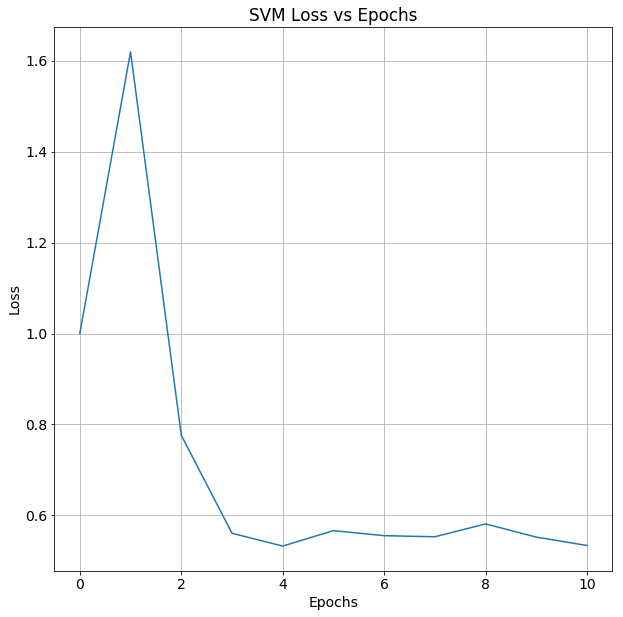

In [13]:
plt.plot(model._train_loss);
plt.title('SVM Loss vs Epochs');
plt.xlabel('Epochs');
plt.ylabel('Loss');

In [14]:
np.random.seed(0)
model = Pegasos()

start = time.time()
model.fit(sparse_movie_train, y_train, num_epochs=100, train_type='optimized')
end = time.time()

print('Elapsed Training Time: {0}'.format(end-start))

Elapsed Training Time: 33.54312181472778


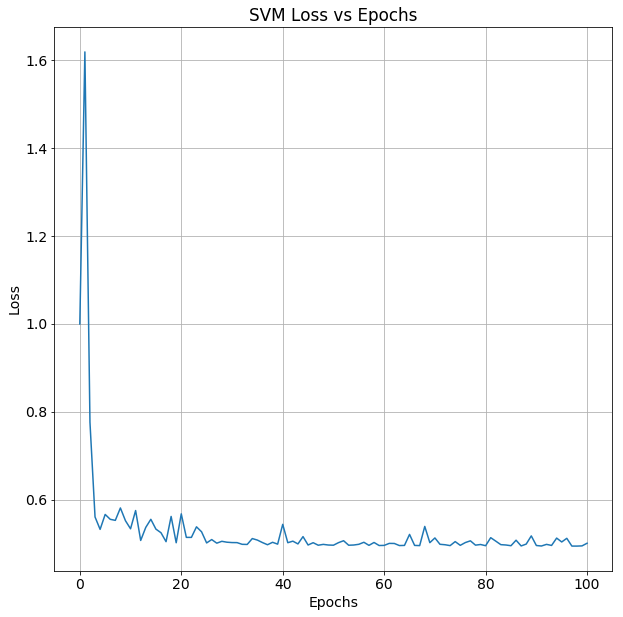

In [15]:
plt.plot(model._train_loss);

plt.title('SVM Loss vs Epochs');
plt.xlabel('Epochs');
plt.ylabel('Loss');

In [16]:
train_predictions = model.predict(sparse_movie_train)
test_predictions = model.predict(sparse_movie_test)

train_acc = accuracy_score(y_train, train_predictions)
test_acc = accuracy_score(y_test, test_predictions)

print('Train Accuracy: {0:0.4}'.format(train_acc))
print('Test Accuracy: {0:0.4}'.format(test_acc))

Train Accuracy: 0.9193
Test Accuracy: 0.802


In [17]:
lambda_vals = np.concatenate((10**np.linspace(-4, 1, 10), 10**np.arange(-3,-1,0.25)))
lambda_vals = np.sort(lambda_vals)
test_accuracies = []
train_accuracies = []

for lambda_reg in tqdm(lambda_vals):
    model = Pegasos(lambda_reg)
    model.fit(sparse_movie_train, y_train, num_epochs=50, train_type='optimized')
    train_predictions = model.predict(sparse_movie_train)
    test_predictions = model.predict(sparse_movie_test)
    
    train_accuracies.append(accuracy_score(y_train, train_predictions))
    test_accuracies.append(accuracy_score(y_test, test_predictions))

100%|██████████| 18/18 [08:17<00:00, 31.64s/it]


In [18]:
index_opt = np.argmax(test_accuracies)
test_accuracy_opt = test_accuracies[index_opt]
lambda_opt = lambda_vals[index_opt]

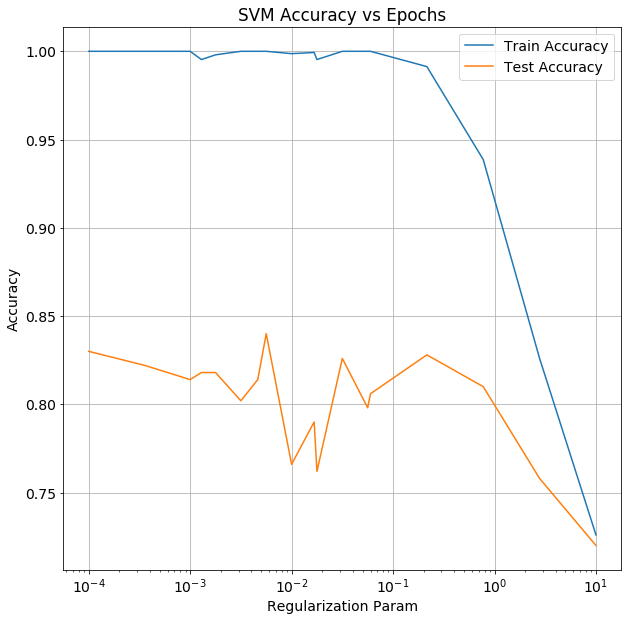

In [19]:
plt.semilogx(lambda_vals, train_accuracies, label='Train Accuracy');
plt.semilogx(lambda_vals, test_accuracies, label='Test Accuracy');

plt.title('SVM Accuracy vs Epochs');
plt.xlabel('Regularization Param');
plt.ylabel('Accuracy');

plt.legend();

In [20]:
model = Pegasos(lambda_opt)
model.fit(sparse_movie_train, y_train, num_epochs=50, train_type='optimized')

train_scores = model.score(sparse_movie_train)
test_scores = model.score(sparse_movie_test)


In [21]:
pos_class_scores = [s for s, label in zip(test_scores, y_test) if label == 1]
neg_class_scores = [s for s, label in zip(test_scores, y_test) if label == -1]

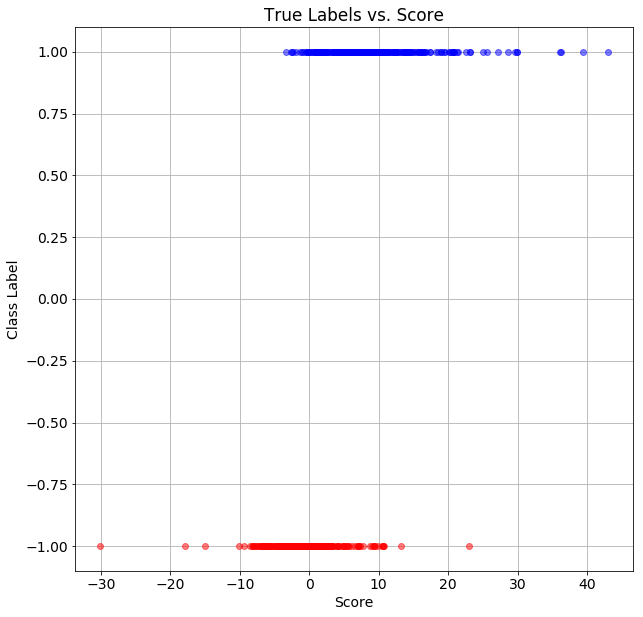

In [22]:
plt.plot(pos_class_scores, np.ones(len(pos_class_scores)), 'bo', alpha=0.5)
plt.plot(neg_class_scores, -np.ones(len(neg_class_scores)), 'ro', alpha=0.5)

plt.title('True Labels vs. Score');
plt.xlabel('Score');
plt.ylabel('Class Label');

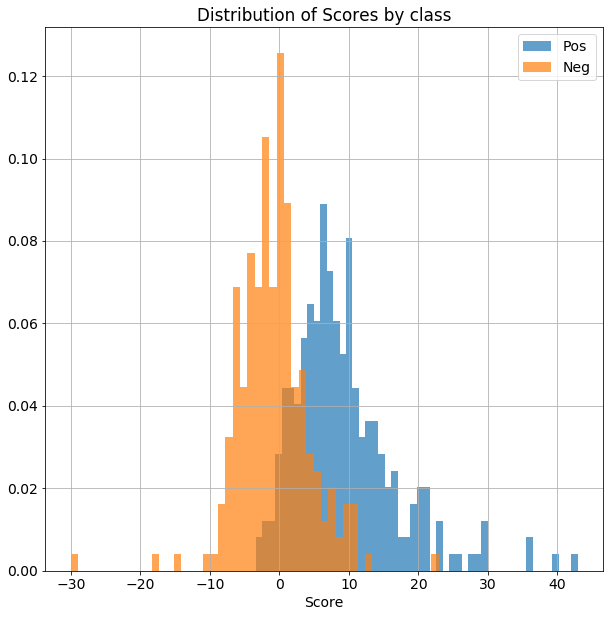

In [24]:
plt.hist(pos_class_scores, density=True, bins=50, alpha=0.7, label='Pos');
plt.hist(neg_class_scores, density=True, bins=50, alpha=0.7, label='Neg');

plt.title('Distribution of Scores by class');
plt.xlabel('Score');
plt.legend();


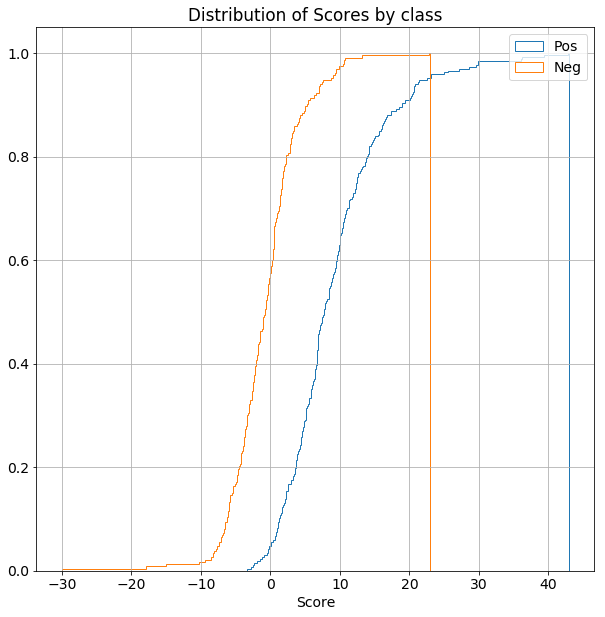

In [25]:
plt.hist(pos_class_scores, cumulative=1,density=True, bins=500, label='Pos',histtype='step');
plt.hist(neg_class_scores, cumulative=1, density=True, bins=500, label='Neg',histtype='step');

plt.title('Distribution of Scores by class');
plt.xlabel('Score');
plt.legend();

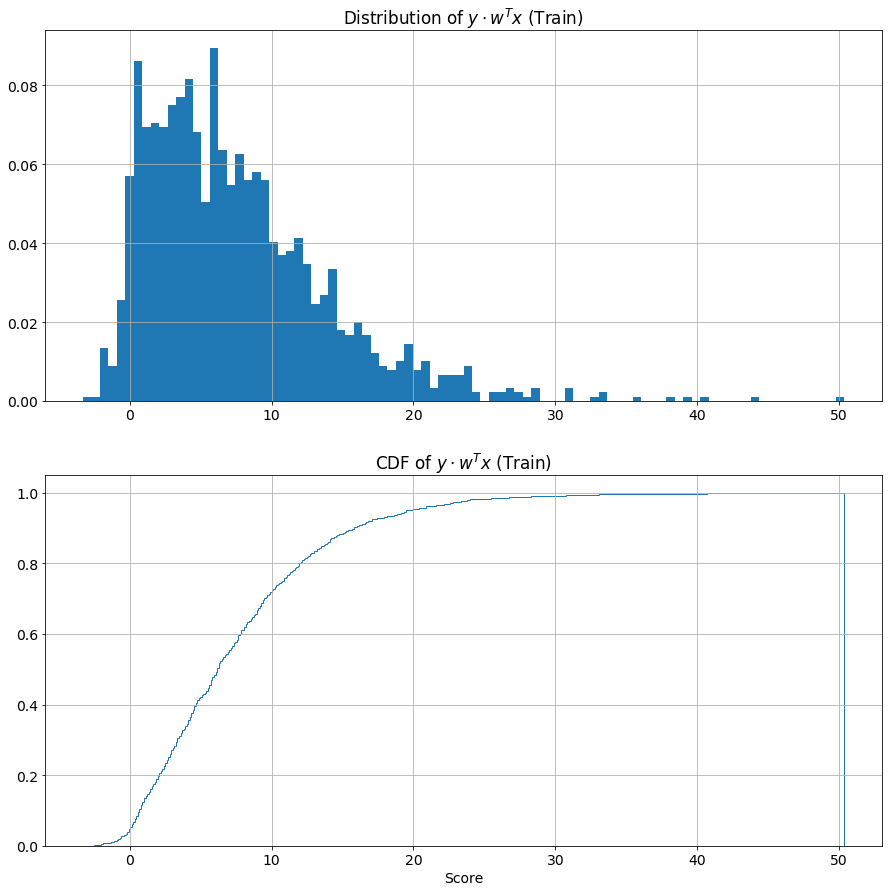

In [26]:
train_decision_boundary = [y * s for y, s in zip(y_train, train_scores)]

plt.figure(figsize=(15,15))
plt.subplot(211);

plt.hist(train_decision_boundary, density=True, bins=90);
plt.title(r'Distribution of $y\cdot w^Tx$ (Train)');

plt.subplot(212);
plt.hist(train_decision_boundary, cumulative=1, density=True, bins=500, label='Pos',histtype='step');

plt.title(r'CDF of $y\cdot w^Tx$ (Train)');
plt.xlabel('Score');


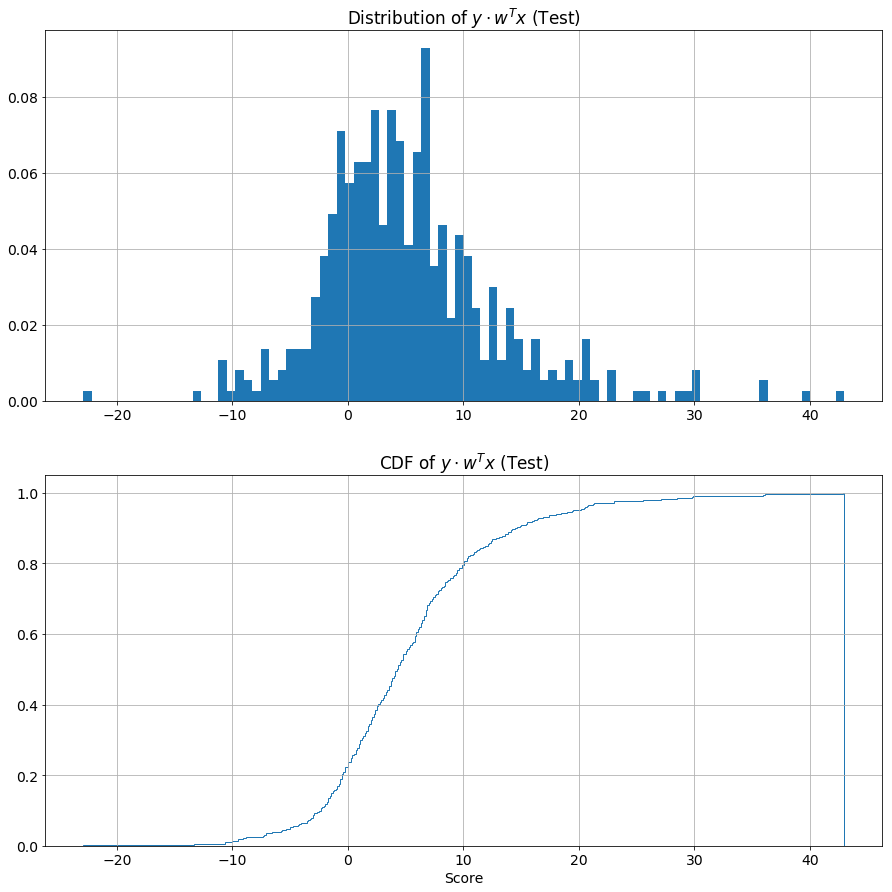

In [27]:
test_decision_boundary = [y * s for y, s in zip(y_test, test_scores)]

plt.figure(figsize=(15,15))
plt.subplot(211);

plt.hist(test_decision_boundary, density=True, bins=90);
plt.title(r'Distribution of $y\cdot w^Tx$ (Test)');

plt.subplot(212);
plt.hist(test_decision_boundary, cumulative=1, density=True, bins=500, label='Pos',histtype='step');

plt.title(r'CDF of $y\cdot w^Tx$ (Test)');
plt.xlabel('Score');

The objective of the SVM loss is non-differentiable when $y\cdot w^Tx = 1$ but as can be seen above, there are a non-trivial number of examples where this occurs. Skipping this update would obviously hinder the quality of our model

# Problem 7

In [28]:
def mislabeled_examples(model, X, y_true, num_mislabeled=5):
    y_pred = model.predict(X)
    errors = [x for x, y1, y2 in zip(X,y_true,y_pred) if y1 != y2]
    return np.random.choice(errors, min([num_mislabeled, len(errors)]), replace=False)

def feature_importance(model, x):
    return sorted([(f, (model._w).get(f, 0) * v) for f, v in x.items()], key = lambda x: -np.abs(x[1]))

In [29]:
test_errors = mislabeled_examples(model, sparse_movie_test, y_test)
for error_example in test_errors: 
    print ('\n'.join(map(str, feature_importance(model, error_example)[:10])))
    print()

('what', 3.030147712736806)
('summer', 2.947162446738545)
('and', 2.456363873548771)
('you', 2.2406021819532733)
('the', 2.095970718356294)
('julie', -1.3846684383711236)
('as', 1.3657003775715193)
('know', -1.3016831723728512)
('in', 1.2234399215744793)
('last', -1.1807617847753753)

('the', 1.849385927961436)
('and', 1.754545623963408)
('bad', -1.673931365565091)
('only', -1.1570517087758752)
('one', 1.1380836479762697)
('in', 1.0195332679787328)
('most', 0.9721131159797199)
('no', -0.9389190095804176)
('is', 0.7302703407847759)
('all', -0.6970762343854628)

('and', 3.1581821231341345)
('this', -2.7740788919421524)
('is', 2.608108359945628)
('the', 2.1576169159550087)
('well', 1.7355775631638013)
('in', 1.427346575170226)
('if', -1.3657003775715204)
('as', 1.3657003775715193)
('nothing', -1.2139558911746875)
('one', 1.1380836479762697)

('first', 1.7355775631638068)
('the', 1.6028011375665778)
('and', 1.5790910615670672)
('one', 1.1380836479762697)
('in', 0.9175799411808595)
('here',

Simple analysis of the errors shows that some of the most important features used to discrimate the data are very high frequency words like 'and', 'the', 'is'. This indicates that using bigrams or trigrams could be useful. Also some more sophisticated weighting scheme like tf-idf rather than just raw counts.

# Problem 8

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import dok_matrix

In [33]:
def scipy_to_bloomberg_sparse(X_dok, index_to_ngram):
    m = X_dok.shape[0]
    bloomberg_sparse = [{} for _ in range(m)]
    for coords, val in X_dok.items():
        i, j = coords
        ngram = index_to_ngram[j]
        bloomberg_sparse[i][ngram] = val
    return bloomberg_sparse

### Tf-Idf Implementation

In [119]:
stop_words = ['is', 'and', 'the', 'that', 'this', 'as', 'to', 'it', 'at', 'of']
vectorizer = TfidfVectorizer(stop_words=stop_words)

X_train = dok_matrix(vectorizer.fit_transform(movie_train_data))
X_test = dok_matrix(vectorizer.transform(movie_test_data))

In [120]:
print('Training set has vocabulary size {0:,}'.format(len(vectorizer.vocabulary_)))

Training set has vocabulary size 39,725


In [121]:
index_to_ngram = {v: k for k, v in vectorizer.vocabulary_.items()}

In [122]:
featurized_movie_train = scipy_to_bloomberg_sparse(X_train, index_to_ngram)
featurized_movie_test = scipy_to_bloomberg_sparse(X_test, index_to_ngram)

In [123]:
lambda_vals = np.concatenate((10**np.linspace(-5, 0, 10), 10**np.linspace(-4,-2,20)))
lambda_vals = np.sort(lambda_vals)
# lambda_vals = [1]
test_accuracies = []
train_accuracies = []

for lambda_reg in tqdm(lambda_vals):
    model = Pegasos(lambda_reg)
    model.fit(featurized_movie_train, y_train, num_epochs=30, train_type='optimized')
    train_predictions = model.predict(featurized_movie_train)
    test_predictions = model.predict(featurized_movie_test)
    
    train_accuracies.append(accuracy_score(y_train, train_predictions))
    test_accuracies.append(accuracy_score(y_test, test_predictions))

100%|██████████| 30/30 [09:23<00:00, 20.46s/it]


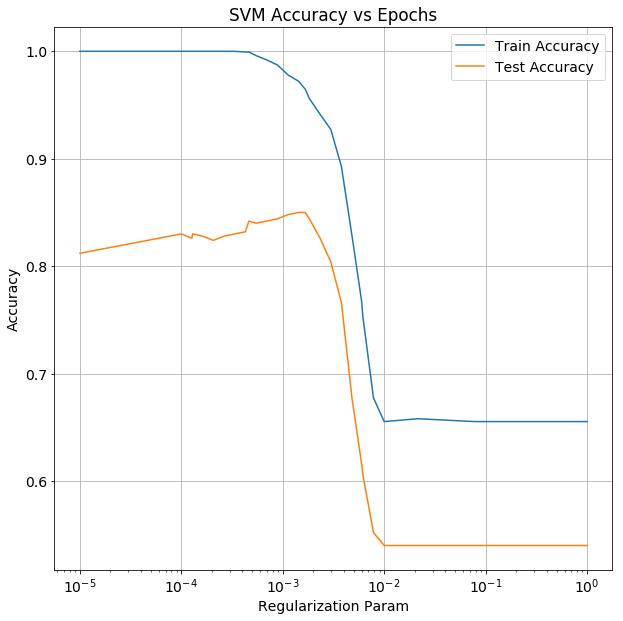

In [124]:
plt.semilogx(lambda_vals, train_accuracies, label='Train Accuracy');
plt.semilogx(lambda_vals, test_accuracies, label='Test Accuracy');

plt.title('SVM Accuracy vs Epochs');
plt.xlabel('Regularization Param');
plt.ylabel('Accuracy');

plt.legend();

In [125]:
index_opt = np.argmax(test_accuracies)
test_accuracy_opt = test_accuracies[index_opt]
lambda_opt = lambda_vals[index_opt]

In [126]:
test_accuracy_opt

0.85

In [127]:
test_errors = mislabeled_examples(model, sparse_movie_test, y_test)
for error_example in test_errors: 
    print ('\n'.join(map(str, feature_importance(model, error_example)[:10])))
    print()

('on', -0.015722715474607966)
('have', -0.015344745626364172)
('movie', -0.014379145977141749)
('her', -0.013961905054659685)
('or', -0.011585843102472909)
('be', -0.0113266675451777)
('out', -0.011036539978911278)
('no', -0.009399575200761734)
('in', -0.008414330149457819)
('about', -0.008375888391179679)

('his', 0.048480239030415095)
('movie', -0.028758291954283498)
('he', 0.01501632875538361)
('only', -0.01093013860211002)
('are', -0.008226367253867897)
('very', 0.007480329689513534)
('in', -0.007212282985249559)
('him', 0.0060375424696309365)
('be', -0.00566333377258885)
('do', -0.0055290999726761055)

('movie', -0.023965243295236246)
('her', -0.020942857581989528)
('be', -0.019821668204060977)
('she', -0.018282809701407776)
('you', -0.01628070627524241)
('all', -0.01531610863748649)
('his', 0.014916996624743106)
('was', -0.013708691294762251)
('so', -0.012866496920523484)
('he', 0.01167936680974281)

('be', -0.008495000658883275)
('she', -0.008125693200625679)
('even', -0.0080560

### Bigram Implementation

In [111]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))#, stop_words=stop_words)

X_train = dok_matrix(vectorizer.fit_transform(movie_train_data))
X_test = dok_matrix(vectorizer.transform(movie_test_data))

print('Training set has vocabulary size {0:,}'.format(len(vectorizer.vocabulary_)))

Training set has vocabulary size 437,139


In [112]:
index_to_ngram = {v: k for k, v in vectorizer.vocabulary_.items()}

In [113]:
featurized_movie_train = scipy_to_bloomberg_sparse(X_train, index_to_ngram)
featurized_movie_test = scipy_to_bloomberg_sparse(X_test, index_to_ngram)

In [114]:
lambda_vals = np.concatenate((10**np.linspace(-4, 2, 10), 10**np.linspace(-2,0,20)))
lambda_vals = np.sort(lambda_vals)
test_accuracies = []
train_accuracies = []

for lambda_reg in tqdm(lambda_vals):
    model = Pegasos(lambda_reg)
    model.fit(featurized_movie_train, y_train, num_epochs=15, train_type='optimized')
    train_predictions = model.predict(featurized_movie_train)
    test_predictions = model.predict(featurized_movie_test)
    
    train_accuracies.append(accuracy_score(y_train, train_predictions))
    test_accuracies.append(accuracy_score(y_test, test_predictions))

100%|██████████| 30/30 [19:55<00:00, 39.55s/it]


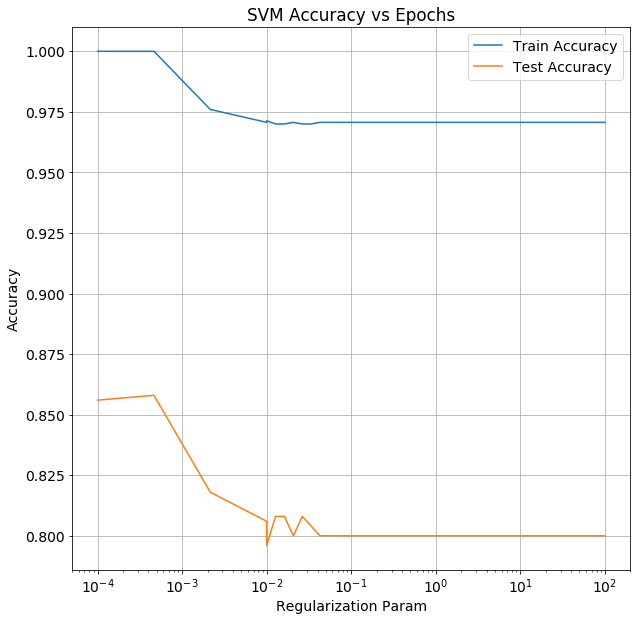

In [115]:
plt.semilogx(lambda_vals, train_accuracies, label='Train Accuracy');
plt.semilogx(lambda_vals, test_accuracies, label='Test Accuracy');

plt.title('SVM Accuracy vs Epochs');
plt.xlabel('Regularization Param');
plt.ylabel('Accuracy');

plt.legend();

In [116]:
index_opt = np.argmax(test_accuracies)
test_accuracy_opt = test_accuracies[index_opt]
lambda_opt = lambda_vals[index_opt]

In [117]:
test_accuracy_opt

0.858

In [118]:
test_errors = mislabeled_examples(model, sparse_movie_test, y_test)
for error_example in test_errors: 
    print ('\n'.join(map(str, feature_importance(model, error_example)[:10])))
    print()

('and', 0.0006241390332439262)
('to', -0.0002322113923519568)
('the', 0.00016719637282297214)
('is', 0.0001460282250411937)
('that', -0.00012239512965330735)
('this', -7.960251563687734e-05)
('of', 7.473826952773025e-05)
('his', 4.768536207855936e-05)
('at', -4.251792353321653e-05)
('all', -4.184089403571994e-05)

('and', 0.0007489668398927114)
('is', 0.0007301411252059685)
('to', -0.0004902240505207977)
('the', 0.00039012486992026836)
('his', 0.00030995485351063585)
('this', -0.00025870817581985137)
('as', 0.00015308629811739625)
('of', 0.0001245637825462171)
('that', -0.00012239512965330735)
('if', -5.513709415169803e-05)

('and', 0.0006241390332439262)
('the', 0.0005127355433237812)
('is', 0.0002920564500823874)
('to', -0.00028381392398572496)
('of', 0.00026158394334705587)
('have', -0.00016121849346679686)
('movie', -0.00012475323404777662)
('even', -8.351262023518352e-05)
('as', 7.654314905869813e-05)
('bad', -6.734643853009287e-05)

('and', 0.000915403915424425)
('the', 0.0004904

### Character Ngram Implementation

In [128]:
vectorizer = TfidfVectorizer(ngram_range=(5,7), analyzer ='char',max_df=0.99, min_df=0.01)

X_train = dok_matrix(vectorizer.fit_transform(movie_train_data))
X_test = dok_matrix(vectorizer.transform(movie_test_data))

print('Training set has vocabulary size {0:,}'.format(len(vectorizer.vocabulary_)))

Training set has vocabulary size 149,172


In [129]:
index_to_ngram = {v: k for k, v in vectorizer.vocabulary_.items()}

In [130]:
featurized_movie_train = scipy_to_bloomberg_sparse(X_train, index_to_ngram)
featurized_movie_test = scipy_to_bloomberg_sparse(X_test, index_to_ngram)

In [131]:
lambda_vals = np.concatenate((10**np.linspace(-5, 0, 10), 10**np.linspace(-4,-2,20)))
lambda_vals = np.sort(lambda_vals)
test_accuracies = []
train_accuracies = []

for lambda_reg in tqdm(lambda_vals):
    model = Pegasos(lambda_reg)
    model.fit(featurized_movie_train, y_train, num_epochs=15, train_type='optimized')
    train_predictions = model.predict(featurized_movie_train)
    test_predictions = model.predict(featurized_movie_test)
    
    train_accuracies.append(accuracy_score(y_train, train_predictions))
    test_accuracies.append(accuracy_score(y_test, test_predictions))

100%|██████████| 30/30 [1:58:06<00:00, 299.31s/it]


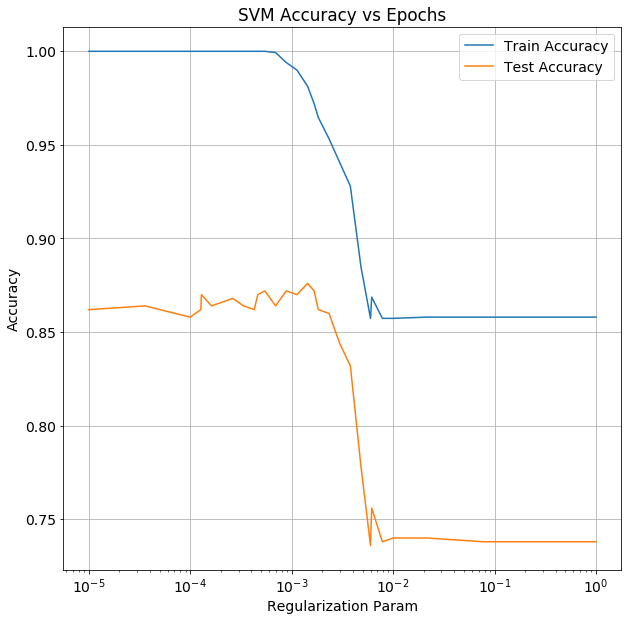

In [132]:
plt.semilogx(lambda_vals, train_accuracies, label='Train Accuracy');
plt.semilogx(lambda_vals, test_accuracies, label='Test Accuracy');

plt.title('SVM Accuracy vs Epochs');
plt.xlabel('Regularization Param');
plt.ylabel('Accuracy');

plt.legend();

In [133]:
index_opt = np.argmax(test_accuracies)
test_accuracy_opt = test_accuracies[index_opt]
lambda_opt = lambda_vals[index_opt]

In [134]:
test_accuracy_opt

0.876